In [2]:
import numpy as np
from torchvision.datasets import CocoDetection
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append("/home/tyfei/cyroem")
import utils
import importlib 
importlib.reload(utils)
import pycocotools.coco
import random
import utils
import pycocotools.mask
import mrcfile

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## build ribo mrc

In [18]:
#build mrc for ribo annotations
ori_file = "/mnt/panbz/lab/transforemer_model/pretrain_data/sull20241102_AA/tomo/sllta0030_9.62Apx.mrc"
data = utils.readTomogram(ori_file) 
df = pd.read_csv("/mnt/panbz/lab/transforemer_model/pretrain_data/sull20241102_AA/ribo/cor_done.star", sep="\s+", skiprows=6, header=None)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_680874/2106220228.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("/mnt/panbz/lab/transforemer_model/pretrain_data/sull20241102_AA/ribo/cor_done.star", sep="\s+", skiprows=6, header=None)


In [17]:
fi_name = os.path.basename(ori_file)
fi_name = fi_name[:fi_name.find(".")]
df["need"] = df[0].apply(lambda x: fi_name in x)
subdf = df[df["need"]]
subdf

,0,1,2,3,need
0,./sllta0030_9.62Apx.mrc_rib_cor.txt,82,564,51,True
1,./sllta0030_9.62Apx.mrc_rib_cor.txt,94,589,52,True
2,./sllta0030_9.62Apx.mrc_rib_cor.txt,84,195,59,True
3,./sllta0030_9.62Apx.mrc_rib_cor.txt,156,931,58,True
4,./sllta0030_9.62Apx.mrc_rib_cor.txt,50,659,66,True
...,...,...,...,...,...
114,./sllta0030_9.62Apx.mrc_rib_cor.txt,890,965,343,True
115,./sllta0030_9.62Apx.mrc_rib_cor.txt,823,735,356,True
116,./sllta0030_9.62Apx.mrc_rib_cor.txt,871,822,353,True
117,./sllta0030_9.62Apx.mrc_rib_cor.txt,799,376,362,True


In [19]:
data = np.zeros_like(data)
for i in range(subdf.shape[0]):
    x, y, z = subdf.iloc[i, 1:4]
    x, y, z = int(x), int(y), int(z)
    data[z-5:z+5, x-6:x+6, y-6:y+6] = i+1

In [20]:
with mrcfile.new('/mnt/panbz/lab/transforemer_model/pretrain_data/sull20241102_AA/ribo/sllta0030_9_ribo.mrc', overwrite=True) as mrc:
    mrc.set_data(data)

In [21]:
data.shape

(500, 1024, 1024)

In [11]:
# build annotations 
categories = [
    {"id": 1, "name": "memb"},
    {"id": 2, "name": "nucleus_memb"},
    {"id": 3, "name": "ribo"},
    {"id": 4, "name": "microtubule"},
    {"id": 5, "name": "actin"},
    {"id": 6, "name": "intermediate_filament"},
    {"id": 7, "name": "nucleus"},
    {"id": 8, "name": "nuclear_pore"},
    {"id": 9, "name": "dense_region_within_the_nucleus"},
    {"id": 10, "name": "Monolamellar_membrane_vesicle_without_contents"},
    {"id": 11, "name": "Monolamellar_membrane_vesicle_with_contents"},
    {"id": 12, "name": "endoplasmic_reticulum_or_Golgi"},
    {"id": 13, "name": "multilayer_membrane_vesicle"},
    {"id": 14, "name": "mitochondria"},
    {"id": 15, "name": "particle"},
]
info = {
    "name": "pretrain dataset",
    "date": str(datetime.datetime.now()),
    "contributor": "Tianyi Fei",
}
licenses = [{"id": 1, "hahaha": 0}]
 


In [13]:
mapping = {} 
for i in categories:
    mapping[i["name"]] = i["id"] 
    
mapping["Newborn_vesicle"] = 10

# ori_file = "/mnt/panbz/lab/transforemer_model/train_data/sull20240716_sllt0051/tomo/sllt0051_9.62Apx.mrc"
ori_file = "/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_005/tomo/TS_005.mrc_10.30Apx.mrc"
output_folder = "/mnt/panbz/lab/transforemer_model/train_data/training/data/TS_005"
mrc_name = "TS_005"

In [15]:
images = [] 
print("building cocodataset for {}".format(ori_file)) 
# load the image
data = utils.readTomogram(ori_file) 
l, h, w = data.shape 

if not os.path.exists(output_folder):
    os.mkdir(output_folder) 
    
for i in range(0, l, 10):
    res = np.zeros((3, h, w))
    res[1] = data[i] 
    res[0] = np.mean(data[max(0, i-10):max(i, 1)], axis=0)
    res[2] = np.mean(data[i:i+10], axis=0) 
    for j in range(3):
        res[j] -= np.min(res[j])
        res[j] /= np.max(res[j])
    img_info = {
        "zpos":float(i),
        "id": len(images) + 1, 
        "license":1, 
        "file_name":"%s/minmax_%i.npy"%(mrc_name, i), 
        "image_name": "%s_%i" % (mrc_name, i),
        "height":h, 
        "width":w, 
        "date_captured":str(datetime.datetime.now())
        } 
    images.append(img_info) 
    np.save("%s/minmax_%i.npy"%(output_folder, i), res)

image_mapping = {} 
for i in images:
    image_mapping[i["image_name"]] = i["id"]

building cocodataset for /mnt/panbz/lab/transforemer_model/train_data/20230328_TS_005/tomo/TS_005.mrc_10.30Apx.mrc


In [23]:
annotations2 = {} 
for i in range(140, 320, 10):
    annotations2["%s_%i" % (mrc_name, i)] = "/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_005/amira/TS_005.mrc_10.30Apx.labels/TS_005.mrc_10.30Apx.labels%d/" % i 
# annotations2 = {'TS_023_140': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels140/',
#  'TS_023_150': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels150/',
#  'TS_023_160': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels160/',
#  'TS_023_170': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels170/',
#  # 'TS_023_180': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels180/',
#  'TS_023_190': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels190/',
#  'TS_023_200': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels200/',
#  'TS_023_210': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels210/',
#  'TS_023_220': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels220/',
#  'TS_023_230': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels230/',
#  'TS_023_240': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels240/',
#  'TS_023_250': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels250/',
#  'TS_023_260': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels260/',
#  'TS_023_270': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels270/',
#  'TS_023_280': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels280/',
#  'TS_023_290': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels290/',
#  'TS_023_300': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels300/',
#  'TS_023_310': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels310/',
#  'TS_023_320': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels320/',
#  'TS_023_330': '/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_023/amira/TS_023.mrc_10.30Apx.labels/TS_023.mrc_10.30Apx.labels330/'}

In [24]:
# ori_file = "/data/test_data_ribo/TS_031.mrc_10.30Apx.mrc"
annotations1 = {
    # "memb":"/mnt/panbz/lab/transforemer_model/train_data/sull20240716_sllt0051/memb/sllt0051_9.62Apx_MemBrain_seg_v9b.ckpt_segmented.label-filtering.mrc", 
    "memb":"/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_005/memb/TS_005.mrc_10.30Apx_MemBrain_seg_v10_alpha.ckpt_segmented(3).Regions.mrc",
    # "ribo":"/mnt/panbz/lab/transforemer_model/train_data/sull20240716_sllt0051/ribo/sllt0051.mrc", 
    "ribo":"/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_005/ribo/TS_005.mrc.mrc",
    # "nucleus_memb":"/mnt/panbz/lab/transforemer_model/train_data/TS_031/uncleus_memb/TS_031.mrc_10.30Apx.labels.mrc",
    # "nucleus_memb":"/data/test_data_ribo/TS_031/uncleus_memb/TS_031.mrc_10.30Apx.labels.mrc",
}
# annotations2 = {'TS_031_130': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels130/',
#  'TS_031_140': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels140/',
#  'TS_031_150': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels150/',
#  'TS_031_160': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels160/',
#  'TS_031_170': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels170/',
#  'TS_031_180': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels180/',
#  'TS_031_190': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels190/',
#  'TS_031_200': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels200/',
#  'TS_031_210': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels210/',
#  'TS_031_220': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels220/',
#  'TS_031_230': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels230/',
#  'TS_031_240': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels240/',
#  'TS_031_250': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels250/',
#  'TS_031_260': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels260/',
#  'TS_031_270': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels270/',
#  'TS_031_280': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels280/',
#  'TS_031_290': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels290/',
#  'TS_031_300': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels300/',
#  'TS_031_310': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels310/',
#  'TS_031_320': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels320/',
#  'TS_031_330': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels330/',
#  'TS_031_340': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels340/',
#  'TS_031_350': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels350/',
#  'TS_031_360': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels360/',
#  'TS_031_370': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels370/',
#  'TS_031_380': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels380/',
#  'TS_031_390': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels390/',
#  'TS_031_400': '/data/test_data_ribo/TS_031/amira/TS_031.mrc_10.30Apx.labels/TS_031.mrc_10.30Apx.labels400/'}

annotations = []

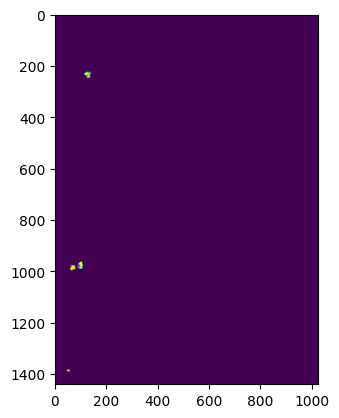

In [18]:
ann_mrc = utils.readTomogram("/mnt/panbz/lab/transforemer_model/train_data/20230328_TS_005/ribo/TS_005.mrc.mrc")
# ann_mrc.shape
plt.imshow(ann_mrc[170])

In [25]:
for ann_id, ann_mrc in annotations1.items():
    ann_id = mapping[ann_id]
    print("processing id, ", ann_id)
    ann_mrc = utils.readTomogram(ann_mrc)
    print(ann_mrc.shape)
    for i in range(0, 500, 10):
        target = ann_mrc[i] 
        for j in np.unique(target):
            if j != 0:
                subarray = target == j
                x, y = np.where(target == j) 
                # subarray = target[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1] > 0 
                subarray = subarray.astype(np.uint8) 
                # subarray = subarray
                subarray = np.asfortranarray(subarray) 
                annotation_info = {'id': len(annotations) + 1,
            'image_id': image_mapping["%s_%s" % (mrc_name, i)],
            'category_id': ann_id,
            "item_id": "%s_%i_%i" % (mrc_name, ann_id, j),
            'bbox': [np.min(y), np.min(x), np.max(y) - np.min(y) + 1, np.max(x) - np.min(x) + 1],
            'area': np.sum(subarray),
            'segmentation': pycocotools.mask.encode(subarray),#{"size":list(subarray.shape), "counts":utils.rleUncompressed(subarray)},
            'iscrowd': 0}
                annotations.append(annotation_info)

processing id,  1
(500, 1440, 1024)
processing id,  3
(500, 1440, 1024)


In [26]:
for image_id, folder in annotations2.items():
    print(image_id)
    for f in os.listdir(folder):
        target = utils.readTomogram(folder+f)
        # target = np.flip(target, axis=0)
        ann_id = mapping[f[:f.find(".")]]
        for j in np.unique(target):
            if j != 0:
                x, y = np.where(target == j) 
                # subarray = target[np.min(x):np.max(x)+1, np.min(y):np.max(y)+1] > 0 
                subarray = target == j
                subarray = subarray.astype(np.uint8) 
                # subarray = subarray
                subarray = np.asfortranarray(subarray) 
                annotation_info = {'id': len(annotations) + 1,
            'image_id': image_mapping[image_id],
            'category_id': ann_id,
            "item_id": "%s_%i_%i" % (mrc_name, ann_id, j),
            'bbox': [np.min(y), np.min(x), np.max(y) - np.min(y) + 1, np.max(x) - np.min(x) + 1],
            'area': np.sum(subarray),
            'segmentation': pycocotools.mask.encode(subarray),#{"size":list(subarray.shape), "counts":utils.rleUncompressed(subarray)},
            'iscrowd': 0}
                annotations.append(annotation_info)

TS_005_140
TS_005_150
TS_005_160
TS_005_170
TS_005_180
TS_005_190
TS_005_200
TS_005_210
TS_005_220
TS_005_230
TS_005_240
TS_005_250
TS_005_260
TS_005_270
TS_005_280
TS_005_290
TS_005_300
TS_005_310


In [27]:
ann = {
    "info":info,
    "licenses":licenses,
    "images":images, 
    "annotations":annotations,
    "categories":categories
}
import pickle
with open("/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/%s.pkl"%mrc_name, "wb") as f:
    pickle.dump(ann, f)

## display dataset

In [ ]:
import modules
import importlib
import os
importlib.reload(modules)
import utils
import matplotlib.pyplot as plt
for i in os.listdir("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/separate/"):
    print(i)
    dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/", 
                            "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/separate/"+i,
                            is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13]}, single_class={"all":False}, add_classname=True, norm="hist", maxsize=800, require_mask=False) 
    data = dataset[20]
    utils.drawannotation(data["pixel_values"], data["labels"]["all"])
    plt.show()
    plt.close()

sll_0008_9.pkl
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


KeyError: 'segmentation'

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


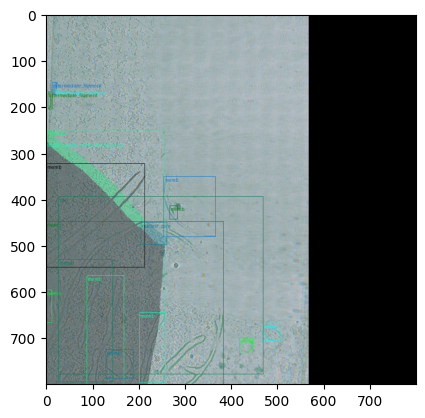

In [18]:
data = dataset[20]
utils.drawannotation(data["pixel_values"], data["labels"]["all"])

## separate dataset

In [41]:
import pickle
with open("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/pretrain_npy_annotations.pkl", "rb") as f:
    ann = pickle.load(f)
tomos = []
for i in ann["images"]:
    file_name = i["file_name"]
    tomos.append(file_name[:file_name.find("/")])
np.unique(tomos), len(np.unique(tomos))

(array(['sll_0008_9', 'sll_0009_9', 'sll_0011_9', 'sll_0012_9',
        'sll_0013_9', 'sll_0015_9', 'sll_0016_9', 'sll_0017_9',
        'sllt0050_9', 'sllt0051_9', 'sllt0052_9', 'sllt0053_9',
        'sllt0054_9', 'sllt0055_9', 'sllt0056_9', 'sllt0057_9',
        'sllt0058_9', 'sllt0059_9', 'sllt0060_9', 'sllt0061_9',
        'sllt0062_9', 'sllt0063_9', 'sllt0064_9', 'sllt0065_9',
        'sllt0066_9', 'sllt0067_9', 'sllt0068_9', 'sllt0069_9',
        'sllt0070_9', 'sllt0071_9', 'sllt0072_9', 'sllt0073_9',
        'sllt0074_9', 'sllt0075_9', 'sllt0076_9', 'sllt0077_9',
        'sllt0078_9', 'sllt0079_9', 'sllt0080_9', 'sllt0081_9',
        'sllt0082_9', 'sllt0083_9', 'sllt0084_9', 'sllt0085_9',
        'sllt0086_9', 'sllt0087_9', 'sllt0088_9', 'sllt0089_9',
        'sllt0090_9', 'sllt0091_9', 'sllt0092_9', 'sllt0093_9',
        'sllt0094_9', 'sllt0095_9', 'sllt0096_9', 'sllta0001_9',
        'sllta0002_9', 'sllta0003_9', 'sllta0004_9', 'sllta0005_9',
        'sllta0006_9', 'sllta0007_9

In [42]:
for i in np.unique(tomos):
    print(i)
    images = []
    annotations = []
    ids = []
    for j in ann["images"]:
        if j["file_name"].find(i) != -1:
            j["zpos"] = float(j["file_name"][j["file_name"].rfind("_")+1:j["file_name"].rfind(".")])
            images.append(j)
            ids.append(j["id"])
    for j in ann["annotations"]:
        if j["image_id"] in ids:
            j["item_id"] = "item"
            annotations.append(j)
    ann2 = {
        "info":info,
        "licenses":licenses,
        "images":images, 
        "annotations":annotations,
        "categories":categories
    }
    with open("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/separate/%s.pkl"%i, "wb") as f:
        pickle.dump(ann2, f)

sll_0008_9
sll_0009_9
sll_0011_9
sll_0012_9
sll_0013_9
sll_0015_9
sll_0016_9
sll_0017_9
sllt0050_9
sllt0051_9
sllt0052_9
sllt0053_9
sllt0054_9
sllt0055_9
sllt0056_9
sllt0057_9
sllt0058_9
sllt0059_9
sllt0060_9
sllt0061_9
sllt0062_9
sllt0063_9
sllt0064_9
sllt0065_9
sllt0066_9
sllt0067_9
sllt0068_9
sllt0069_9
sllt0070_9
sllt0071_9
sllt0072_9
sllt0073_9
sllt0074_9
sllt0075_9
sllt0076_9
sllt0077_9
sllt0078_9
sllt0079_9
sllt0080_9
sllt0081_9
sllt0082_9
sllt0083_9
sllt0084_9
sllt0085_9
sllt0086_9
sllt0087_9
sllt0088_9
sllt0089_9
sllt0090_9
sllt0091_9
sllt0092_9
sllt0093_9
sllt0094_9
sllt0095_9
sllt0096_9
sllta0001_9
sllta0002_9
sllta0003_9
sllta0004_9
sllta0005_9
sllta0006_9
sllta0007_9
sllta0008_9
sllta0009_9
sllta0010_9
sllta0011_9
sllta0012_9
sllta0013_9
sllta0014_9
sllta0015_9
sllta0016_9
sllta0030_9
sllta0031_9
sllta0032_9
sllta0033_9
sllta0034_9
sllta0035_9
sllta0036_9
slltb0015_9
slltb0016_9
slltb0017_9
slltb0018_9
slltb0019_9
slltb0020_9
slltb0021_9
slltb0022_9
slltb0023_9
slltb0024_9

## filter data

In [47]:
filter_data = list(range(5, 30))
ori_file = "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/separate/sllt0061_9.pkl"

In [48]:
# build annotations 
categories = [
    {"id": 1, "name": "memb"},
    {"id": 2, "name": "nucleus_memb"},
    {"id": 3, "name": "ribo"},
    {"id": 4, "name": "microtubule"},
    {"id": 5, "name": "actin"},
    {"id": 6, "name": "intermediate_filament"},
    {"id": 7, "name": "nucleus"},
    {"id": 8, "name": "nuclear_pore"},
    {"id": 9, "name": "dense_region_within_the_nucleus"},
    {"id": 10, "name": "Monolamellar_membrane_vesicle_without_contents"},
    {"id": 11, "name": "Monolamellar_membrane_vesicle_with_contents"},
    {"id": 12, "name": "endoplasmic_reticulum_or_Golgi"},
    {"id": 13, "name": "multilayer_membrane_vesicle"},
    {"id": 14, "name": "mitochondria"},
    {"id": 15, "name": "particle"},
]
info = {
    "name": "pretrain dataset",
    "date": str(datetime.datetime.now()),
    "contributor": "Tianyi Fei",
}
licenses = [{"id": 1, "hahaha": 0}]
 


In [49]:
with open(ori_file, "rb") as f:
    ann = pickle.load(f)
need_id = []
need_images = []
need_annotations = []
for i, j in enumerate(ann["images"]):
    if i in filter_data:
        need_images.append(j)
        need_id.append(j["id"])
for i in ann["annotations"]:
    if i["image_id"] in need_id:
        need_annotations.append(i)
ann2 = {
    "info":info,
    "licenses":licenses,
    "images":need_images, 
    "annotations":need_annotations,
    "categories":categories
}
with open("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/filtered/sllt0061_9.pkl", "wb") as f:
    pickle.dump(ann2, f)

In [50]:
import modules
dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/", 
                        "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/filtered/sllt0061_9.pkl",
                        is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13]}, single_class={"all":False}, add_classname=True, maxsize=800) 


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/home/feity/cryoem/utils.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


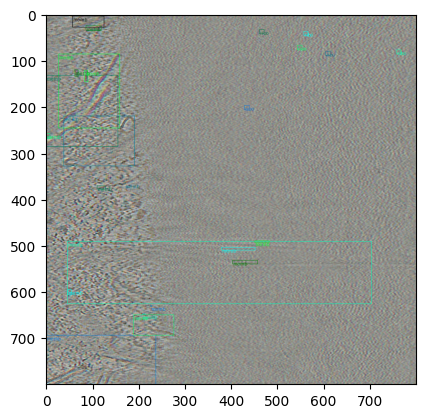

In [51]:
data = dataset[2]
utils.drawannotation(data["pixel_values"], data["labels"]["all"])